In [1]:
import ast

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import wandb

In [2]:
api = wandb.Api()

In [3]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [12]:
def get_experiment_data(filters, name, keys):
    runs = api.runs("bartekcupial/sf2_nethack", filters=filters)
    data = []
    for run in runs:
        try:
            # df = run.history(samples=30000, keys=[key])
            df = {key: run.summary[key] for key in keys}
            df = pd.DataFrame(df)
            df["seed"] = run.config["seed"]
            df["train/env_steps"] = run.summary_metrics["train/env_steps"]
            df["name"] = name
            df["exp_tag"] = ast.literal_eval(run.config["exp_tags"])[0]
            
            df = df.assign(ItemList=df[keys[0]].apply(lambda x: [x] if isinstance(x, int) else x)).explode('ItemList')
            del df["ItemList"]
        
            data.append(df)
        except Exception as e:
            pass

    df = pd.concat(data, axis=0).reset_index()
    df.reset_index(drop=True, inplace=True)
    return df

In [13]:
appo = get_experiment_data({"config.exp_tags": "['2024_01_28_eval_APPO']"}, "appo", ["reward_p0", "dlvl_p0", "sokobanfillpit_score_p0"])

In [22]:
data = []
for exp_tag, name in zip(
    [
        "['2024_01_28_eval_APPO']", 
        "['2024_01_28_eval_APPO-T']", 
        "['2024_01_28_eval_APPO-KS-T']", 
        "['2024_01_28_eval_APPO-BC-T']",
        "['2024_01_28_eval_dlvl4_APPO']", 
        "['2024_01_28_eval_dlvl4_APPO-T']", 
        "['2024_01_28_eval_dlvl4_APPO-KS-T']", 
        "['2024_01_28_eval_dlvl4_APPO-BC-T']",
        "['2024_01_28_eval_sokoban_APPO']", 
        "['2024_01_28_eval_sokoban_APPO-T']", 
        "['2024_01_28_eval_sokoban_APPO-KS-T']", 
        "['2024_01_28_eval_sokoban_APPO-BC-T']",
    ],
    [
        "appo", 
        "appo_t", 
        "appo_ks_t", 
        "appo_bc_t",
        "appo", 
        "appo_t", 
        "appo_ks_t", 
        "appo_bc_t",
        "appo", 
        "appo_t", 
        "appo_ks_t", 
        "appo_bc_t",
    ],
):
    df = get_experiment_data({"config.exp_tags": exp_tag}, name, ["reward_p0", "dlvl_p0", "sokobanfillpit_score_p0"])
    data.append(df)
   
data = pd.concat(data, axis=0).reset_index()

In [23]:
data["index"] = data["train/env_steps"] - data["train/env_steps"] % 5_000_000

/tmp/ipykernel_129668/1175152261.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3153.020123839009' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  method_data.loc[method_data['index'] == 0, eval_column] = baseline_val
/tmp/ipykernel_129668/1175152261.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3153.020123839009' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  method_data.loc[method_data['index'] == 0, eval_column] = baseline_val
/tmp/ipykernel_129668/1175152261.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3153.020123839009' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  method_data.loc[method_data['index'] == 0, eval_column] = ba

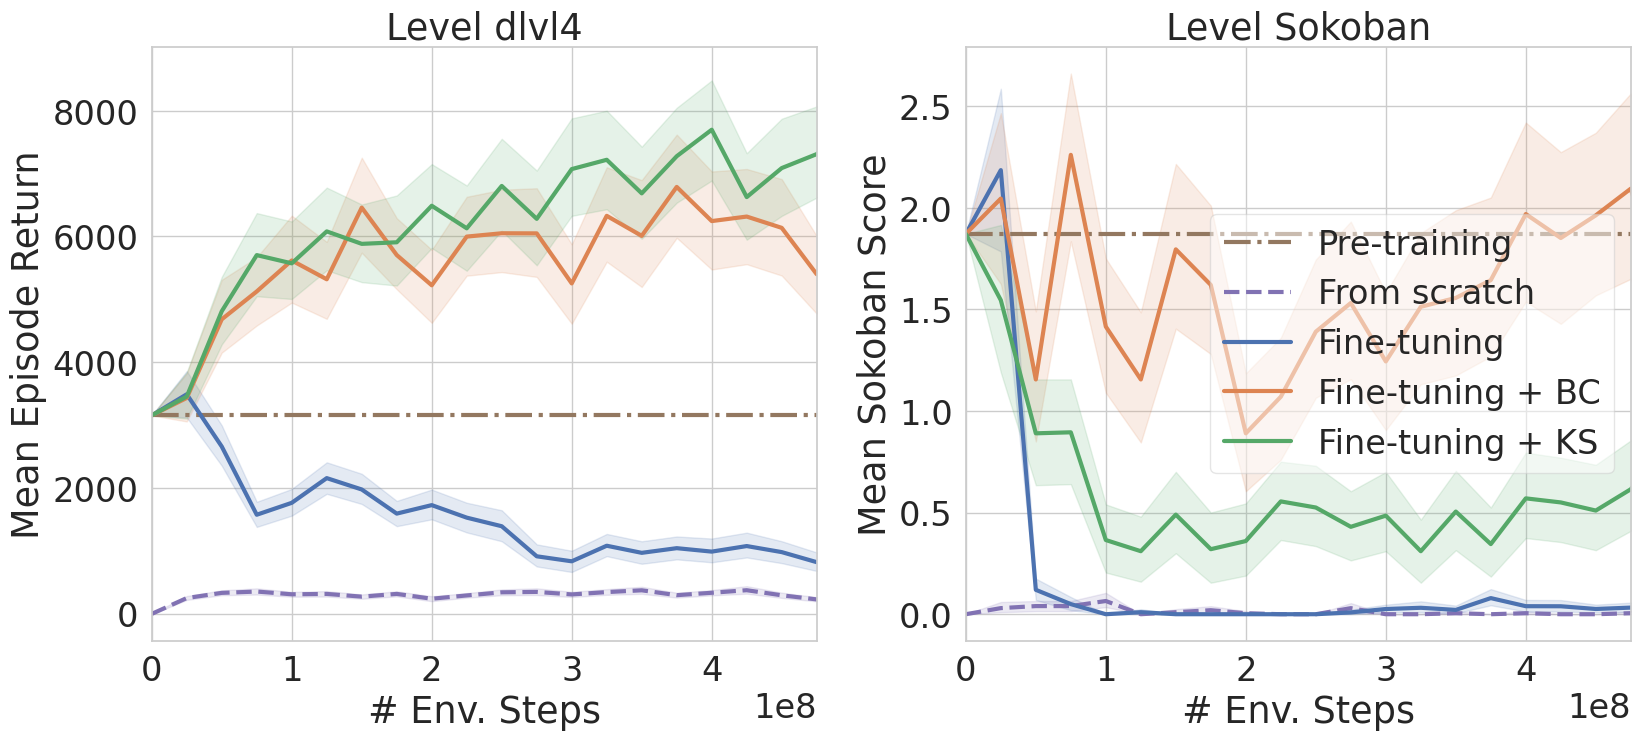

In [24]:
n_rows = 1
n_cols = 2
sns.set(font_scale=2.2)
sns.set_style('whitegrid')

fig, axes = plt.subplots(n_rows, n_cols, figsize=(17, 8))

axes = axes.flatten()
legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

method_translator = {
    "appo": "From scratch",
    "appo_t": "Fine-tuning",
    "appo_bc_t": "Fine-tuning + BC",
    "appo_ks_t": "Fine-tuning + KS",
}

sns_colors = sns.color_palette()
# sns_colors = sns_colors[]
colors = {
    "From scratch": sns_colors[4],
    "Fine-tuning": sns_colors[0],
    "Fine-tuning + BC": sns_colors[1],
    "Fine-tuning + KS": sns_colors[2],
}

levels = ["dlvl4", "sokoban"]

for idx, (ax, level) in enumerate(zip(axes, levels)):
    eval_column = "sokobanfillpit_score_p0" if level == "sokoban" else "reward_p0"
    data_level = data[data["exp_tag"].str.contains(level)]

    # [0 - 500M]
    baseline_val = data_level[(data_level['index'] == 0) & (data_level['name'].str.contains('_t'))][eval_column].mean()
    ax.plot([0, 500_000_000], [baseline_val, baseline_val], linestyle='-.', label="Pre-training", linewidth=3, color=sns_colors[5])
    for e, (method, method_name) in enumerate(method_translator.items()):

        method_data = data_level[data_level["name"] == method]

        if '_t' in method:
            method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        legend = "full" if idx == len(levels) - 1 else None
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=('ci', 90), linewidth=3,
                        legend=legend, label=method_name, linestyle="-" if method_name != "From scratch" else "--",
                        err_kws={"alpha": .15}, color=colors[method_name])

        if legend is not None:
            ax.legend(loc="center right", framealpha=0.5)
        if idx == len(levels) - 1:
            ax.set_ylabel("Mean Sokoban Score")
        else:
            ax.set_ylabel("Mean Episode Return")

        ax.set_xlabel("# Env. Steps")
        ax.set_xlim(0, 475_000_000)

        level_name = level if level != "None" else "Level start"
        level_name = "Sokoban" if level == "sokoban" else level_name.replace('saves', '')
        ax.set_title(f"Level {level_name}")

plt.tight_layout()

# Show or save the plot
plt.show()

In [25]:
data

,level_0,index,reward_p0,dlvl_p0,sokobanfillpit_score_p0,seed,train/env_steps,name,exp_tag
0,0,275000000,32,1,0,4,275001344,appo,2024_01_28_eval_APPO
1,1,275000000,184,1,0,4,275001344,appo,2024_01_28_eval_APPO
2,2,275000000,28,1,0,4,275001344,appo,2024_01_28_eval_APPO
3,3,275000000,662,1,0,4,275001344,appo,2024_01_28_eval_APPO
4,4,275000000,1072,1,0,4,275001344,appo,2024_01_28_eval_APPO
...,...,...,...,...,...,...,...,...,...
50706,3840,0,0,1,0,0,0,appo_bc_t,2024_01_28_eval_sokoban_APPO-BC-T
50707,3841,0,0,1,0,0,0,appo_bc_t,2024_01_28_eval_sokoban_APPO-BC-T
50708,3842,0,0,1,0,0,0,appo_bc_t,2024_01_28_eval_sokoban_APPO-BC-T
50709,3843,0,0,1,0,0,0,appo_bc_t,2024_01_28_eval_sokoban_APPO-BC-T


/tmp/ipykernel_129668/589289502.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.572085889570552' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  method_data.loc[method_data['index'] == 0, eval_column] = baseline_val
/tmp/ipykernel_129668/589289502.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.572085889570552' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  method_data.loc[method_data['index'] == 0, eval_column] = baseline_val
/tmp/ipykernel_129668/589289502.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.572085889570552' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  method_data.loc[method_data['index'] == 0, eval_column] = basel

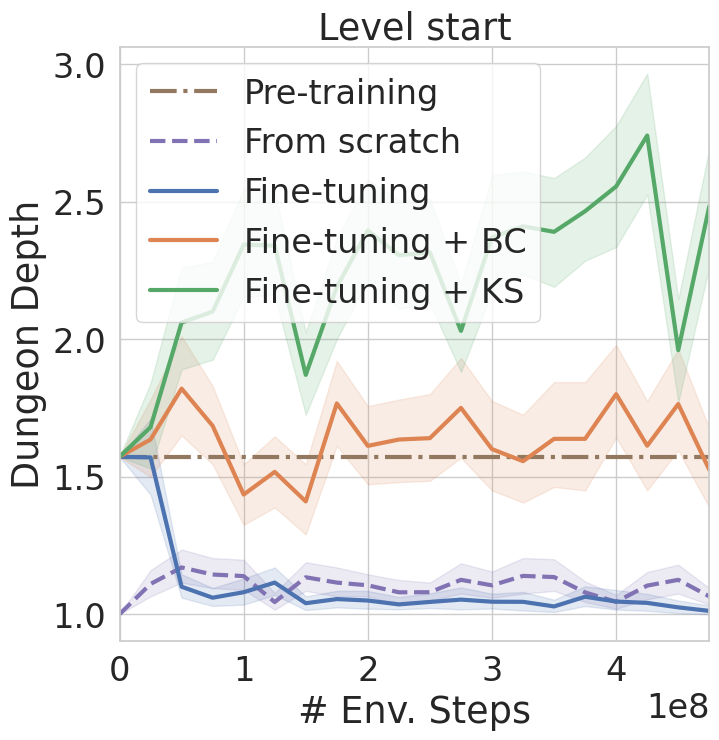

In [33]:
n_rows = 1
n_cols = 1
sns.set(font_scale=2.2)
sns.set_style('whitegrid')

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))

axes = [axes]
# axes = axes.flatten()
legend_handles = []  # Create an empty list to collect legend handles
legend_labels = []   # Create an empty list to collect legend labels

method_translator = {
    "appo": "From scratch",
    "appo_t": "Fine-tuning",
    "appo_bc_t": "Fine-tuning + BC",
    "appo_ks_t": "Fine-tuning + KS",
}

sns_colors = sns.color_palette()
# sns_colors = sns_colors[]
colors = {
    "From scratch": sns_colors[4],
    "Fine-tuning": sns_colors[0],
    "Fine-tuning + BC": sns_colors[1],
    "Fine-tuning + KS": sns_colors[2],
}

levels = ["eval_APPO"]

for idx, (ax, level) in enumerate(zip(axes, levels)):
    eval_column = "sokobanfillpit_score_p0" if level == "sokoban" else "dlvl_p0"
    data_level = data[data["exp_tag"].str.contains(level)]

    # [0 - 500M]
    baseline_val = data_level[(data_level['index'] == 0) & (data_level['name'].str.contains('_t'))][eval_column].mean()
    ax.plot([0, 500_000_000], [baseline_val, baseline_val], linestyle='-.', label="Pre-training", linewidth=3, color=sns_colors[5])
    for e, (method, method_name) in enumerate(method_translator.items()):

        method_data = data_level[data_level["name"] == method]

        if '_t' in method:
            method_data.loc[method_data['index'] == 0, eval_column] = baseline_val

        legend = "full" #if idx == len(levels) - 1 else None
        sns.lineplot(data=method_data, x="index", y=eval_column, ax=ax, errorbar=('ci', 90), linewidth=3,
                        legend=legend, label=method_name, linestyle="-" if method_name != "From scratch" else "--",
                        err_kws={"alpha": .15}, color=colors[method_name])

        # if legend is not None:
        #     ax.legend(loc="center right", framealpha=0.5)
        ax.set_ylabel("Dungeon Depth")

        ax.set_xlabel("# Env. Steps")
        ax.set_xlim(0, 475_000_000)

        ax.set_title(f"Level start")

plt.tight_layout()

# Show or save the plot
plt.show()